In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.svm import SVC, LinearSVC

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split

In [2]:
def calculate_cdf(series, num_points=512):
    sorted_series = np.sort(series)
    cdf = np.arange(1, len(sorted_series) + 1) / len(sorted_series)
    sampled_points = np.linspace(np.min(sorted_series), np.max(sorted_series), num_points)
    sampled_cdf = np.interp(sampled_points, sorted_series, cdf)
    return sampled_cdf

In [10]:
def load_dataset(files):
    data_arr = []
    count = 0
    for file_path in files:
        data_raw = pd.read_csv(file_path).values.astype(np.float32)
        if len(data_raw[:, 1]) == 0:
            print(f"Warning: No data in {file_path}")
            continue

        if len(data_raw[:, 1]) < 10000:
            count += 1
        # data = np.expand_dims(data_raw[:, 1], axis=1)
        cdf_features = calculate_cdf(data_raw[:, 1])        
        data_arr.append(cdf_features)
    
    print(f"Number of files with less than 1000 data points: {count}")
    return np.array(data_arr)

In [4]:
data_storage = {
    'map': {
        'dirs': [
            './secure_sgx_dataset/map',
            './nexmark_dataset/q1',
            './nexmark_dataset/q2_map',
            './nexmark_dataset/q4_map',
        ],
        'label': 0
    },
    'filter': {
        'dirs': [
            './secure_sgx_dataset/filter',
            './nexmark_dataset/q2_filter',
            './nexmark_dataset/q3_filter_auction',
            './nexmark_dataset/q3_filter_person',
            './nexmark_dataset/q6_filter',
        ],
        'label': 1
    },
    'reduce': {
        'dirs': [
            './nexmark_dataset/q4_join_auction_bid',
        ],
        'label': 2
    }
}

In [5]:
data_files = {}
for operator in data_storage:
    data_files[operator] = {
        'files': [],
        'label': data_storage[operator]['label']
    }

    for dir in data_storage[operator]['dirs']:
        files = [f for f in os.listdir(dir) if f.endswith('.csv')]
        data_files[operator]['files'].extend([os.path.join(dir, file) for file in files])

In [6]:
data_files

{'map': {'files': ['./secure_sgx_dataset/map/tail_0_326_Add_the_product_of_dayOfWeek_and_distance_to_depDelay.csv',
   './secure_sgx_dataset/map/tail_0_82_Assign_flightNumber_as_the_difference_between_year_and_depTime_modulo_9999.csv',
   './secure_sgx_dataset/map/tail_0_195_Assign_arrDelay_to_the_number_of_1_bits_in_depTime.csv',
   './secure_sgx_dataset/map/tail_0_95_Set_year_as_the_minimum_of_arrTime_and_depTime_modulo_2000.csv',
   './secure_sgx_dataset/map/tail_0_346_Assign_depDelay_to_the_sum_of_the_squares_of_depTime_and_arrTime_modulo_100000.csv',
   './secure_sgx_dataset/map/tail_0_185_Assign_arrDelay_to_the_modulo_100_of_distance.csv',
   './secure_sgx_dataset/map/tail_0_203_If_dayOfMonth_is_even__halve_the_distance.csv',
   './secure_sgx_dataset/map/tail_0_282_Assign_depDelay_as_the_absolute_difference_between_arrTime_and_depTime.csv',
   './secure_sgx_dataset/map/tail_0_58_Set_flightNumber_as_the_reverse_of_distance_bits.csv',
   './secure_sgx_dataset/map/tail_0_55_Set_year

In [7]:
for operator in data_files:
    train, test = train_test_split(data_files[operator]['files'], train_size=0.8, shuffle=True, random_state=42)
    data_files[operator]['train'] = train
    data_files[operator]['test'] = test

    # val, test = train_test_split(temp, train_size=0.5, shuffle=True, random_state=42)
    # data_files[operator]['val'] = val
    # data_files[operator]['test'] = test


In [8]:
train_files = []
# val_files = []
test_files = []

train_labels = []
# val_labels = []
test_labels = []

for operator in data_files:
    train_files.extend(data_files[operator]['train'])
    train_labels.extend([data_files[operator]['label']]*len(data_files[operator]['train']))

    # val_files.extend(data_files[operator]['val'])
    # val_labels.extend([data_files[operator]['label']]*len(data_files[operator]['val']))

    test_files.extend(data_files[operator]['test'])
    test_labels.extend([data_files[operator]['label']]*len(data_files[operator]['test']))

In [11]:
train_set = load_dataset(train_files)
# val_set = load_dataset(val_files, val_labels)
test_set = load_dataset(test_files)

Number of files with less than 1000 data points: 6
Number of files with less than 1000 data points: 0


In [11]:
train_labels = np.array(train_labels[:len(train_set)])
test_labels = np.array(test_labels[:len(test_set)])

In [12]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    print("Training Classification Report:")
    print(classification_report(y_train, train_preds))
    print("Test Classification Report:")
    print(classification_report(y_test, test_preds))

    print("Confusion Matrix (Test):")
    print(confusion_matrix(y_test, test_preds))

    # ROC Curve
    y_score = model.predict_proba(X_test)
    plt.figure()
    for i in range(len(np.unique(y_test))):
        fpr, tpr, _ = roc_curve([1 if y == i else 0 for y in y_test], y_score[:, i])
        plt.plot(fpr, tpr, label=f'Class {i} (area = {roc_auc_score([1 if y == i else 0 for y in y_test], y_score[:, i]):.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1006
           1       1.00      1.00      1.00      1319
           2       1.00      1.00      1.00       807

    accuracy                           1.00      3132
   macro avg       1.00      1.00      1.00      3132
weighted avg       1.00      1.00      1.00      3132

Test Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.89       252
           1       0.96      0.85      0.90       330
           2       1.00      1.00      1.00       201

    accuracy                           0.92       783
   macro avg       0.93      0.93      0.93       783
weighted avg       0.92      0.92      0.92       783

Confusion Matrix (Test):
[[240  12   0]
 [ 50 279   1]
 [  0   1 200]]


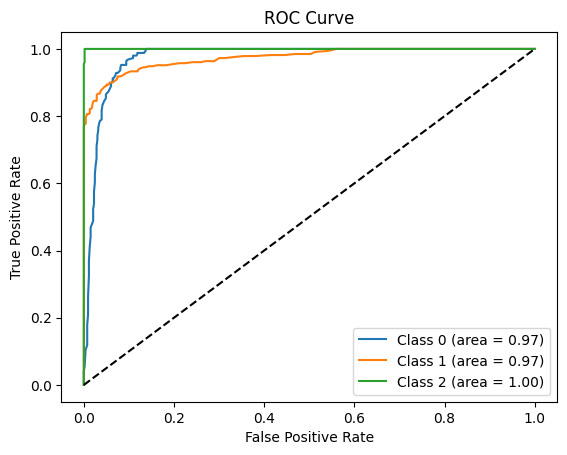

In [13]:
model_rf = RandomForestClassifier(n_estimators=100)
train_and_evaluate(model_rf, train_set, train_labels, test_set, test_labels)

Training Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.84      0.74      1006
           1       0.81      0.63      0.71      1319
           2       0.93      0.96      0.95       807

    accuracy                           0.78      3132
   macro avg       0.80      0.81      0.80      3132
weighted avg       0.80      0.78      0.78      3132

Test Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.83      0.72       252
           1       0.81      0.60      0.69       330
           2       0.94      0.98      0.96       201

    accuracy                           0.77       783
   macro avg       0.79      0.80      0.79       783
weighted avg       0.79      0.77      0.77       783

Confusion Matrix (Test):
[[209  42   1]
 [119 199  12]
 [  0   5 196]]


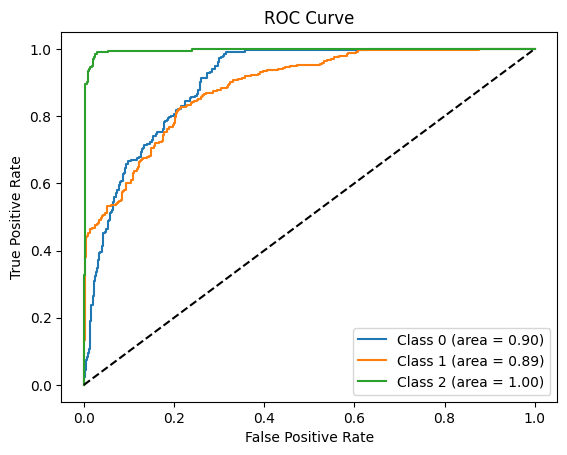

In [14]:
model_svm = SVC(probability=True)
train_and_evaluate(model_svm, train_set, train_labels, test_set, test_labels)

In [28]:
class TimeSeriesDataset(Dataset):
    def __init__(self, files, label_dict):
        self.label_dict = label_dict
        self.files = files
        self.labels = []

        self.data = []
        for idx, file_path in enumerate(self.files):
            data_raw = pd.read_csv(file_path).values.astype(np.float32)
            if len(data_raw[:, 1]) == 0:
                print(f"Warning: No data in {file_path}")
                continue
            cdf_features = calculate_cdf(data_raw[:, 1])
            self.data.append(cdf_features)
            self.labels.append(self.label_dict[idx])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

In [16]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)

In [17]:
def evaluate_nn(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    accuracy = 100 * correct / total
    return total_loss / len(loader), accuracy


In [18]:
def train_nn(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=20):
    model.to(device)
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        val_loss, val_acc = evaluate_nn(model, val_loader, criterion, device)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')

In [19]:
for operator in data_files:
    val, test = train_test_split(data_files[operator]['test'], train_size=0.5, shuffle=True, random_state=42)
    data_files[operator]['val'] = val
    data_files[operator]['test_2'] = test

In [20]:
train_files = []
val_files = []
test_files = []

train_labels = []
val_labels = []
test_labels = []

for operator in data_files:
    train_files.extend(data_files[operator]['train'])
    train_labels.extend([data_files[operator]['label']]*len(data_files[operator]['train']))

    val_files.extend(data_files[operator]['val'])
    val_labels.extend([data_files[operator]['label']]*len(data_files[operator]['val']))

    test_files.extend(data_files[operator]['test_2'])
    test_labels.extend([data_files[operator]['label']]*len(data_files[operator]['test_2']))

In [29]:
train_set = TimeSeriesDataset(train_files, train_labels)
val_set = TimeSeriesDataset(val_files, val_labels)
test_set = TimeSeriesDataset(test_files, test_labels)

In [30]:
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16, shuffle=False)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)

In [31]:
device = torch.device("cpu")

In [32]:
input_size = 512
num_classes = 3

model = SimpleNN(input_size=input_size, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [33]:
train_nn(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=100)

Epoch [1/100], Loss: 1.0493, Val Loss: 0.9294, Val Acc: 42.0918
Epoch [2/100], Loss: 0.6934, Val Loss: 0.5702, Val Acc: 74.4898
Epoch [3/100], Loss: 0.5700, Val Loss: 0.5484, Val Acc: 72.7041
Epoch [4/100], Loss: 0.5377, Val Loss: 0.5474, Val Acc: 73.2143
Epoch [5/100], Loss: 0.5501, Val Loss: 0.5671, Val Acc: 72.7041
Epoch [6/100], Loss: 0.5475, Val Loss: 0.5645, Val Acc: 74.4898
Epoch [7/100], Loss: 0.5316, Val Loss: 0.6449, Val Acc: 65.8163
Epoch [8/100], Loss: 0.5330, Val Loss: 0.6010, Val Acc: 71.1735
Epoch [9/100], Loss: 0.5402, Val Loss: 0.5680, Val Acc: 64.7959
Epoch [10/100], Loss: 0.5354, Val Loss: 0.5372, Val Acc: 75.5102
Epoch [11/100], Loss: 0.5308, Val Loss: 0.5361, Val Acc: 75.2551
Epoch [12/100], Loss: 0.5238, Val Loss: 0.5585, Val Acc: 72.1939
Epoch [13/100], Loss: 0.5328, Val Loss: 0.5809, Val Acc: 72.7041
Epoch [14/100], Loss: 0.5325, Val Loss: 0.5369, Val Acc: 76.7857
Epoch [15/100], Loss: 0.5256, Val Loss: 0.5426, Val Acc: 76.2755
Epoch [16/100], Loss: 0.5210, Val 

In [34]:
# Load the best model for evaluation
model.load_state_dict(torch.load('best_model.pth'))
_, test_acc = evaluate_nn(model, test_loader, criterion, device)
print(f'Test Accuracy: {test_acc:.2f}%')


Test Accuracy: 76.21%
